In [50]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def sigmoid(x):
  
    z = np.exp(-x)
    sig = 1 / (1 + z)

    return sig

In [18]:
G = nx.fast_gnp_random_graph(15, .2, seed = 123)

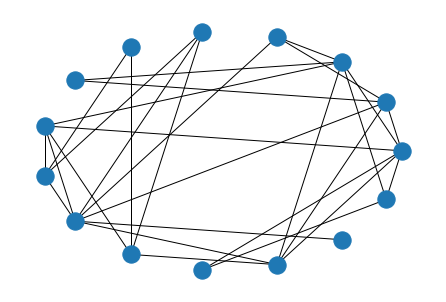

In [19]:
nx.draw_circular(G)

In [25]:
np.random.seed(123)
for s,t in G.edges:
    G[s][t]['weight'] = np.random.uniform(0,1)

In [26]:
for s,t in G.edges:
    print(G.get_edge_data(s,t))

{'weight': 0.6964691855978616}
{'weight': 0.28613933495037946}
{'weight': 0.2268514535642031}
{'weight': 0.5513147690828912}
{'weight': 0.7194689697855631}
{'weight': 0.42310646012446096}
{'weight': 0.9807641983846155}
{'weight': 0.6848297385848633}
{'weight': 0.48093190148436094}
{'weight': 0.3921175181941505}
{'weight': 0.3431780161508694}
{'weight': 0.7290497073840416}
{'weight': 0.4385722446796244}
{'weight': 0.05967789660956835}
{'weight': 0.3980442553304314}
{'weight': 0.7379954057320357}
{'weight': 0.18249173045349998}
{'weight': 0.17545175614749253}
{'weight': 0.5315513738418384}
{'weight': 0.5318275870968661}
{'weight': 0.6344009585513211}
{'weight': 0.8494317940777896}
{'weight': 0.7244553248606352}
{'weight': 0.6110235106775829}
{'weight': 0.7224433825702216}
{'weight': 0.3229589138531782}
{'weight': 0.3617886556223141}
{'weight': 0.22826323087895561}
{'weight': 0.29371404638882936}


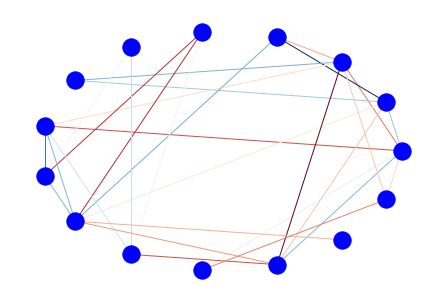

In [33]:
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw_circular(G,node_color='b', edgelist=edges, edge_color=weights, width=1.0, edge_cmap=plt.cm.RdBu)

In [37]:
L = nx.laplacian_matrix(G).toarray()
normL = (L.shape[0]/np.trace(L))*L

In [39]:
w, chi = np.linalg.eig(normL)

In [125]:
def generate_signal(alpha, h, chi):
    P = (chi@h + alpha*np.ones(len(h)))
    X = [sigmoid(p) for p in P]
    for i in range(len(X)):
        test = np.random.uniform(0,1)
        if test < X[i]:
            X[i] = 1
        else:
            X[i] = 0
    return X

In [136]:
np.random.seed(123)
h = np.random.normal(0,1, 15)
np.random.seed(123)
vals = np.random.uniform(0,1,20)
alpha = []
for i in vals:
    alpha = alpha + [i]*5

In [137]:
Y = []
for a in alpha:
    Y.append(generate_signal(a,h,chi))
Y = np.transpose(np.array(Y))
Y.shape

(15, 100)

In [138]:
hmap = list((1/100)*Y@np.ones(100))
D = {i:hmap[i] for i in range(len(hmap))}
nx.set_node_attributes(G, D, "group")

In [139]:
nx.get_node_attributes(G, "group")

{0: 0.5900000000000002,
 1: 0.8700000000000003,
 2: 0.42000000000000015,
 3: 0.5300000000000001,
 4: 0.4700000000000002,
 5: 0.6200000000000002,
 6: 0.060000000000000005,
 7: 0.7000000000000002,
 8: 0.3900000000000001,
 9: 0.41000000000000014,
 10: 0.9400000000000003,
 11: 0.3400000000000001,
 12: 0.38000000000000017,
 13: 0.2800000000000001,
 14: 0.6100000000000003}

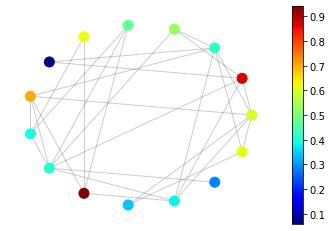

In [140]:
# create number for each group to allow use of colormap
from itertools import count
# get unique groups
groups = set(nx.get_node_attributes(G,'group').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [G.nodes[n]['group'] for n in nodes]
node_sizes = [1000*i for i in mapping.keys()]
# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.circular_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, 
                            nodelist=nodes, 
                            node_color=colors, node_size=100, 
                            cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

[0.6964691855978616,
 0.6964691855978616,
 0.6964691855978616,
 0.6964691855978616,
 0.6964691855978616,
 0.28613933495037946,
 0.28613933495037946,
 0.28613933495037946,
 0.28613933495037946,
 0.28613933495037946,
 0.2268514535642031,
 0.2268514535642031,
 0.2268514535642031,
 0.2268514535642031,
 0.2268514535642031,
 0.5513147690828912,
 0.5513147690828912,
 0.5513147690828912,
 0.5513147690828912,
 0.5513147690828912,
 0.7194689697855631,
 0.7194689697855631,
 0.7194689697855631,
 0.7194689697855631,
 0.7194689697855631,
 0.42310646012446096,
 0.42310646012446096,
 0.42310646012446096,
 0.42310646012446096,
 0.42310646012446096,
 0.9807641983846155,
 0.9807641983846155,
 0.9807641983846155,
 0.9807641983846155,
 0.9807641983846155,
 0.6848297385848633,
 0.6848297385848633,
 0.6848297385848633,
 0.6848297385848633,
 0.6848297385848633,
 0.48093190148436094,
 0.48093190148436094,
 0.48093190148436094,
 0.48093190148436094,
 0.48093190148436094,
 0.3921175181941505,
 0.3921175181941505